## 1. Library Import

In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
# import torch.nn.functional as F

from PIL import Image
from collections import Counter
from tqdm.notebook import tqdm

from typing import Callable, Optional
from torch.utils import data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from torch import nn
from torchvision import models
from sklearn.model_selection import KFold

import torch.nn.functional as F
import wandb

## 2. Config Info

In [2]:
sort_optimizer = ["Adam", "Momentum", "SGD"]
sort_model = ["resnet34", "resnet152", "wide_resnet50_2", "vgg19", "inception_v3", "custom"]

class config_info:
    main_dirpath = '/opt/ml/input/data/train'
    image_dirpath = f'{main_dirpath}/images'
    csv_dirpath = f'{main_dirpath}/train.csv'
    new_csv_path = f'{main_dirpath}/new_train.csv'
    
    test_dir = '/opt/ml/input/data/eval'
    model_path = '/opt/ml/model'
    testset_ratio = 0.1
    
    epochs=100
    k_fold_split = 5
    learning_rate = 1e-3
    batch_size = 108             # 18, 21, 27, 28, 36, 42, 54, 63, 84, 108
    num_workers = 4
    
    model = "resnet152"
    optimizer = "Adam"
    momentum=0.9

In [3]:
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.001

wandb_config={"testset_ratio" : config_info.testset_ratio,
              "k-fold" : config_info.k_fold_split,
              
              "batch_size" : config_info.batch_size,
              
              "model" : config_info.model,
              "optimizer": config_info.optimizer,
              
              "epochs" : config_info.epochs,
              "learning_rate" : config_info.learning_rate,
             }
wandb.init(project="Mask-Classification", entity='falling90', config=wandb_config, name="Resize384,288")

wandb: Currently logged in as: falling90 (use `wandb login --relogin` to force relogin)

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



## 3. Data Analysis

### 1) 분석할 Image 폴더 List 생성

In [4]:
def get_image_dirlist(maindir, csv_path):
    result = []
    csv_df = pd.read_csv(csv_path)

    for line in csv_df['path']:
        result.append(os.path.join(maindir, line))
    
    return result
    
print(f"폴더 개수(사람 수) : {len(get_image_dirlist(config_info.image_dirpath, config_info.csv_dirpath))}")

폴더 개수(사람 수) : 2700


### 2) 분석할 Image 폴더 존재여부 Check

In [5]:
def scan_dir_error(image_dirlist):
    error_indexlist = []
    for idx, dirpath in enumerate(image_dirlist):
        if not os.path.isdir(dirpath):
            error_indexlist.append(idx)

    return error_indexlist

print(f"폴더 유실 개수 : {len(scan_dir_error(get_image_dirlist(config_info.image_dirpath, config_info.csv_dirpath)))}")

폴더 유실 개수 : 0


### 3) 파일 정보 Summary 확인 (폴더 별 Image 개수 / 전체 Image 개수 / 확장자 종류)

In [7]:
def get_file_summary(image_dirlist):
    count_list = []
    extension_list = []
    
    for each_dir in image_dirlist:
        filelist = glob.glob(os.path.join(each_dir, "*.*"))
        
        count_list.append(str(len(filelist)) + "장")
        for eachfile in filelist:
            extension_list.append(os.path.splitext(eachfile)[1])
#     print(Counter(count_list), Counter(extension_list))
#     print(f"총 Image수 : {len(ImagePathList)}")

    return dict(Counter(count_list)), len(extension_list), dict(Counter(extension_list))

eachdir_image_count, all_image_count, extension_count = get_file_summary(get_image_dirlist(config_info.image_dirpath, config_info.csv_dirpath))

print(f"폴더 별 Image 개수 : {eachdir_image_count}\n전체 Image 개수 : {all_image_count}\n확장자 종류 개수 : {extension_count}")

폴더 별 Image 개수 : {'7장': 2700}
전체 Image 개수 : 18900
확장자 종류 개수 : {'.jpg': 18035, '.png': 511, '.jpeg': 354}


### 4) Image 경로 List 생성

In [9]:
def get_image_path_List(image_dirlist):
    image_fullpath_List = []
    
    for each_dir in image_dirlist:
        filelist = glob.glob(os.path.join(each_dir, "*.*"))
        for eachfile in filelist:
            image_fullpath_List.append(eachfile)
    
    return image_fullpath_List

print_term = 6000
print(f"> Image_FullPath List")
for idx, imagepath in enumerate(get_image_path_List(get_image_dirlist(config_info.image_dirpath, config_info.csv_dirpath))):
    if (idx+1) % print_term == 1:
        print(idx+1, imagepath)
    elif (idx+1) % print_term == 2:
        print("...")
print(idx+1, imagepath)

> Image_FullPath List
1 /opt/ml/input/data/train/images/000001_female_Asian_45/mask2.jpg
...
6001 /opt/ml/input/data/train/images/001603_male_Asian_23/incorrect_mask.jpg
...
12001 /opt/ml/input/data/train/images/003945_male_Asian_53/mask4.jpg
...
18001 /opt/ml/input/data/train/images/006609_male_Asian_19/normal.jpeg
...
18900 /opt/ml/input/data/train/images/006959_male_Asian_19/normal.jpg


## 4. Data Labeling

## 4. Data Labeling

### 1) Labeling Class 선언

In [10]:
class Data_Labeling():
    def __init__(self, image_name, gender, age):
        self.image_name = image_name
        self.gender = gender
        self.age = age

    def __getitem__(self, data):
        if data == "class":
            return 6 * self.get_mask_class(self.image_name) + 3 * self.get_gender_class(self.gender) + self.get_age_class(self.age)
#             return self.get_mask_class(self.image_name)
#             return self.get_gender_class(self.gender)
#             return self.get_age_class(self.age)

    def get_mask_class(self, image_name):
        if image_name.lower().startswith("mask"):
            return 0
        elif image_name.lower().startswith("incorrect"):
            return 1
        elif image_name.lower().startswith("normal"):
            return 2
        else:
            return -1

    def get_gender_class(self, gender):
        if gender.lower() == "male":
            return 0
        elif gender.lower() == "female":
            return 1
        else:
            return -1

    def get_age_class(self, age):
        if age < 30:
            return 0
        elif age >= 30 and age < 60:
            return 1
        elif age >= 60:
            return 2

print(Data_Labeling("incorrect_mask.jpg", "male", 23)['class'])

6


### 2) 전체 Image Labeling 후 DataFrame으로 반환

In [11]:
def get_mask_state(image_name):
    if image_name.lower().startswith("mask"):
        return "Wear"
    elif image_name.lower().startswith("incorrect"):
        return "Incorrect"
    elif image_name.lower().startswith("normal"):
        return "Not Wear"
    else:
        return "Error"

In [12]:
def get_labelingdata_to_dataframe(image_path_List):
    allimage_list = image_path_List

    line = []
    All_Data = []
    
    for path in  allimage_list:
        try:
            split_data = path.split("/")
            image_name = split_data[len(split_data)-1]
            
            person_info = split_data[len(split_data)-2].split("_")
            
            person_id = person_info[0]
            person_gender = person_info[1]
            person_race = person_info[2]
            person_age = person_info[3]
            person_mask = get_mask_state(image_name)
            person_image_name = os.path.splitext(image_name)[0]
            person_image_extension = os.path.splitext(image_name)[1]
            person_image_fullpath = path
            
            person_age = int(person_age)
            person_class = Data_Labeling(image_name, person_gender, person_age)['class']
            
        except:
            person_class = -1
            continue
        
        All_Data.append([person_id, person_gender, person_race, person_age, person_mask, person_class, person_image_name, person_image_extension, person_image_fullpath])
        
    Result_DataFrame = pd.DataFrame(All_Data, columns=["ID", "Gender", "Race", "Age", "Mask", "Class", "Imagename", "ImageExtension", "ImageFullPath"])
    Result_DataFrame = Result_DataFrame.sort_values(by='ImageFullPath')
    Result_DataFrame = Result_DataFrame.reset_index(drop=True)
    return Result_DataFrame

pd.set_option('max_columns', None)
pd.set_option('max_colwidth', None)

image_dirlist = get_image_dirlist(config_info.image_dirpath, config_info.csv_dirpath)
image_path_List = get_image_path_List(image_dirlist)
labelingdata_dataframe = get_labelingdata_to_dataframe(image_path_List)

### 3) Data Noise 제거

In [13]:
def get_noise_filtered_dataframe(labelingdata_dataframe):
    original_dataframe = labelingdata_dataframe
    new_dataframe = pd.read_csv(config_info.new_csv_path)

    result_dataframe = pd.merge(original_dataframe, new_dataframe, left_on='ImageFullPath', right_on='Full Path')
    result_dataframe.drop(result_dataframe.columns[9], axis=1, inplace=True)
    result_dataframe.drop(result_dataframe.columns[10:], axis=1, inplace=True)
    result_dataframe.columns=["ID", "Gender", "Race", "Age", "Mask", "Class", "Imagename", "ImageExtension", "ImageFullPath", "NewClass"]

    return result_dataframe

noise_filtered_dataframe = get_noise_filtered_dataframe(labelingdata_dataframe)
noise_filtered_dataframe[noise_filtered_dataframe['Class'] != noise_filtered_dataframe['NewClass']]

,ID,Gender,Race,Age,Mask,Class,Imagename,ImageExtension,ImageFullPath,NewClass
105,000020,female,Asian,50,Incorrect,10,incorrect_mask,.jpg,/opt/ml/input/data/train/images/000020_female_Asian_50/incorrect_mask.jpg,16
111,000020,female,Asian,50,Not Wear,16,normal,.jpg,/opt/ml/input/data/train/images/000020_female_Asian_50/normal.jpg,10
217,000039,female,Asian,57,Incorrect,10,incorrect_mask,.jpg,/opt/ml/input/data/train/images/000039_female_Asian_57/incorrect_mask.jpg,11
218,000039,female,Asian,57,Wear,4,mask1,.jpg,/opt/ml/input/data/train/images/000039_female_Asian_57/mask1.jpg,5
219,000039,female,Asian,57,Wear,4,mask2,.jpg,/opt/ml/input/data/train/images/000039_female_Asian_57/mask2.jpg,5
...,...,...,...,...,...,...,...,...,...,...
16830,006364,female,Asian,18,Wear,3,mask2,.jpg,/opt/ml/input/data/train/images/006364_female_Asian_18/mask2.jpg,0
16831,006364,female,Asian,18,Wear,3,mask3,.jpg,/opt/ml/input/data/train/images/006364_female_Asian_18/mask3.jpg,0
16832,006364,female,Asian,18,Wear,3,mask4,.jpg,/opt/ml/input/data/train/images/006364_female_Asian_18/mask4.jpg,0
16833,006364,female,Asian,18,Wear,3,mask5,.jpg,/opt/ml/input/data/train/images/006364_female_Asian_18/mask5.jpg,0


### 4) 최종 DataFrame 생성 함수 (Image 폴더 경로 입력 시 DataFrame 반환)

In [14]:
def get_final_dataframe(image_dirlist):
    image_path_List = get_image_path_List(image_dirlist)
    labelingdata_dataframe = get_labelingdata_to_dataframe(image_path_List)
    result_dataframe = get_noise_filtered_dataframe(labelingdata_dataframe)
    
    return result_dataframe

image_dirlist = get_image_dirlist(config_info.image_dirpath, config_info.csv_dirpath)
df = get_final_dataframe(image_dirlist)
df

,ID,Gender,Race,Age,Mask,Class,Imagename,ImageExtension,ImageFullPath,NewClass
0,000001,female,Asian,45,Incorrect,10,incorrect_mask,.jpg,/opt/ml/input/data/train/images/000001_female_Asian_45/incorrect_mask.jpg,10
1,000001,female,Asian,45,Wear,4,mask1,.jpg,/opt/ml/input/data/train/images/000001_female_Asian_45/mask1.jpg,4
2,000001,female,Asian,45,Wear,4,mask2,.jpg,/opt/ml/input/data/train/images/000001_female_Asian_45/mask2.jpg,4
3,000001,female,Asian,45,Wear,4,mask3,.jpg,/opt/ml/input/data/train/images/000001_female_Asian_45/mask3.jpg,4
4,000001,female,Asian,45,Wear,4,mask4,.jpg,/opt/ml/input/data/train/images/000001_female_Asian_45/mask4.jpg,4
...,...,...,...,...,...,...,...,...,...,...
18895,006959,male,Asian,19,Wear,0,mask2,.jpg,/opt/ml/input/data/train/images/006959_male_Asian_19/mask2.jpg,0
18896,006959,male,Asian,19,Wear,0,mask3,.jpg,/opt/ml/input/data/train/images/006959_male_Asian_19/mask3.jpg,0
18897,006959,male,Asian,19,Wear,0,mask4,.jpg,/opt/ml/input/data/train/images/006959_male_Asian_19/mask4.jpg,0
18898,006959,male,Asian,19,Wear,0,mask5,.jpg,/opt/ml/input/data/train/images/006959_male_Asian_19/mask5.jpg,0


## 5. Data Augmentation

### 1) Transform

In [15]:
from albumentations import *
from albumentations.pytorch import ToTensorV2

def get_transforms(train: bool = True, img_resize=(256, 192), centercrop_size=(256, 192), mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2), viewmode=False):
    transformations = {}

    if not viewmode:
        if train:
            transformations = Compose([Resize(img_resize[0], img_resize[1], p=1.0),
                                       ShiftScaleRotate(p=0.5),
#                                        CenterCrop(centercrop_size[0], centercrop_size[1]),
                                       HorizontalFlip(p=0.5),
#                                        HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
#                                        RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
#                                        GaussNoise(p=0.5),                                       
                                       Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
                                       ToTensorV2(p=1.0)
                                      ])
        else:
            transformations = Compose([Resize(img_resize[0], img_resize[1], p=1.0),
#                                        CenterCrop(centercrop_size[0], centercrop_size[1]),
                                       Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
                                       ToTensorV2(p=1.0)
                                      ])
    else:
        if train:
            transformations = Compose([Resize(img_resize[0], img_resize[1], p=1.0),
                                        ShiftScaleRotate(p=0.5),
#                                         CenterCrop(centercrop_size[0], centercrop_size[1]),
                                        HorizontalFlip(p=0.5),
#                                         HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
#                                         RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
#                                         GaussNoise(p=0.5),
#                                        Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
#                                        ToTensorV2(p=1.0)
                                      ])
        else:
            transformations = Compose([Resize(img_resize[0], img_resize[1], p=1.0),
#                                        CenterCrop(centercrop_size[0], centercrop_size[1]),
                                       #Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
                                       #ToTensorV2(p=1.0)
                                      ])

    return transformations

## 6. Dataset

In [16]:
class My_Dataset(Dataset):
    def __init__(self, image_path, indexes = None, label: Optional[Callable] = None, trans_train : Optional[Callable] = True, 
                                     train: Optional[Callable] = True, transform: Optional[Callable] = None):
        super(My_Dataset, self).__init__()
        
        self.image_path = image_path
        self.label = label
        self.trans_train = trans_train
        self.train = train
        self.transform = transform

    def __len__(self):
        len_dataset = len(self.image_path)
        return len_dataset

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_path[idx]))
        
        if self.transform is not None:
            image_height, image_width, image_channel = image.shape
            image_mean = image.mean(axis=(0,1)) / 255.
            image_std = image.std(axis=(0,1)) / 255.
            image = self.transform(image=image, train=self.trans_train, img_resize=(384, 288), centercrop_size=(384, 288))#, mean=image_mean, std=image_std)
#             image = self.transform(image=image, train=self.trans_train, img_resize=(256, 192))
            
            if self.train:
                target = self.label[idx]
                return [image['image'], target]
            else:
                return image['image']
        
        if self.train:
            target = self.label[idx]
            return [image, target]
        else:
            return image

In [17]:
def get_dataset(image_dirlist, trans_train = True, train=True, viewmode=False):
    datainfo = get_final_dataframe(image_dirlist)

    image_paths = datainfo['ImageFullPath']
    labels = datainfo['NewClass']

    transforms = get_transforms(train=trans_train, viewmode=viewmode)
    dataset = My_Dataset(image_path=image_paths, label=labels, train=train, transform=transforms)
    
    return dataset

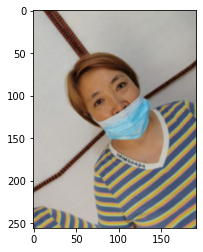

In [18]:
image_dirlist = get_image_dirlist(config_info.image_dirpath, config_info.csv_dirpath)
my_dataset = get_dataset(image_dirlist, trans_train=True, train=True, viewmode=True)
X, y = my_dataset[0]

fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8, 4))
axes.imshow(np.array(X))
plt.show()

## 7. Dataloader

### 1) Train, Test Data Split

In [19]:
import numpy as np
def get_age_class_condition(dataframe):
    conditions = [
        (dataframe['Age'] < 30),
        (dataframe['Age'] >= 30) & (dataframe['Age'] < 60),
        (dataframe['Age'] >= 60)
    ]
    values = ['Age_1(-29)', 'Age_2(30-59)', 'Age_3(60-)']
    return conditions, values

In [20]:
def get_ratio(dataframe, group, desc):
    columns = np.transpose(dataframe.groupby(group)[group])[0]
    total = 0
    result_ratio = dict()
    
    for column in columns:
        result_ratio[column] = int(dataframe.groupby(group)[group].get_group(column).count())
    total = sum(list(result_ratio.values()))
    
    print(f"{desc} >", end=" ")
    for key, value in result_ratio.items():
        print(f"{key} : {value} ({(value/total)*100:.2f}%), ", end=" ")
    print()

In [21]:
image_dirlist = get_image_dirlist(config_info.image_dirpath, config_info.csv_dirpath)
test_num = int(len(image_dirlist) * config_info.testset_ratio)
train_num = len(image_dirlist) - test_num

train_image_dirlist, test_dirlist = data.random_split(image_dirlist, [train_num, test_num])
# train_image_dirlist, test_dirlist = image_dirlist[0:train_num], image_dirlist[train_num:]
# print(len(train_image_dirlist), len(test_dirlist))

In [22]:
final_dataframe = get_final_dataframe(image_dirlist)
test_final_dataframe = get_final_dataframe(test_dirlist)

conditions, values = get_age_class_condition(final_dataframe)
final_dataframe['Age_Class'] = np.select(conditions, values)

conditions, values = get_age_class_condition(test_final_dataframe)
test_final_dataframe['Age_Class'] = np.select(conditions, values)
test_final_dataframe

,ID,Gender,Race,Age,Mask,Class,Imagename,ImageExtension,ImageFullPath,NewClass,Age_Class
0,000029,female,Asian,58,Incorrect,10,incorrect_mask,.jpg,/opt/ml/input/data/train/images/000029_female_Asian_58/incorrect_mask.jpg,10,Age_2(30-59)
1,000029,female,Asian,58,Wear,4,mask1,.jpg,/opt/ml/input/data/train/images/000029_female_Asian_58/mask1.jpg,4,Age_2(30-59)
2,000029,female,Asian,58,Wear,4,mask2,.jpg,/opt/ml/input/data/train/images/000029_female_Asian_58/mask2.jpg,4,Age_2(30-59)
3,000029,female,Asian,58,Wear,4,mask3,.jpg,/opt/ml/input/data/train/images/000029_female_Asian_58/mask3.jpg,4,Age_2(30-59)
4,000029,female,Asian,58,Wear,4,mask4,.jpg,/opt/ml/input/data/train/images/000029_female_Asian_58/mask4.jpg,4,Age_2(30-59)
...,...,...,...,...,...,...,...,...,...,...,...
1885,006957,male,Asian,20,Wear,0,mask2,.jpg,/opt/ml/input/data/train/images/006957_male_Asian_20/mask2.jpg,0,Age_1(-29)
1886,006957,male,Asian,20,Wear,0,mask3,.jpg,/opt/ml/input/data/train/images/006957_male_Asian_20/mask3.jpg,0,Age_1(-29)
1887,006957,male,Asian,20,Wear,0,mask4,.jpg,/opt/ml/input/data/train/images/006957_male_Asian_20/mask4.jpg,0,Age_1(-29)
1888,006957,male,Asian,20,Wear,0,mask5,.jpg,/opt/ml/input/data/train/images/006957_male_Asian_20/mask5.jpg,0,Age_1(-29)


In [23]:
get_ratio(final_dataframe, "Gender", "Total")
get_ratio(test_final_dataframe, "Gender", "Test")
print()

get_ratio(final_dataframe, "Mask", "Total")
get_ratio(test_final_dataframe, "Mask", "Test")
print()

get_ratio(final_dataframe, "Age_Class", "Total")
get_ratio(test_final_dataframe, "Age_Class", "Test")

Total > female : 11606 (61.41%),  male : 7294 (38.59%),  
Test > female : 1162 (61.48%),  male : 728 (38.52%),  

Total > Incorrect : 2700 (14.29%),  Not Wear : 2700 (14.29%),  Wear : 13500 (71.43%),  
Test > Incorrect : 270 (14.29%),  Not Wear : 270 (14.29%),  Wear : 1350 (71.43%),  

Total > Age_1(-29) : 8967 (47.44%),  Age_2(30-59) : 8589 (45.44%),  Age_3(60-) : 1344 (7.11%),  
Test > Age_1(-29) : 1057 (55.93%),  Age_2(30-59) : 714 (37.78%),  Age_3(60-) : 119 (6.30%),  


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [24]:
# aaaaaaaaaaa

### 2) Testset Loader 생성

In [25]:
dataset = get_dataset(test_dirlist, trans_train=False, train=True, viewmode=False)

test_loader = DataLoader(
    dataset,
    batch_size=config_info.batch_size,
    num_workers=config_info.num_workers,
)

### 3) Training, Validation Data Split (in Train Data)
> K-Fold 적용 (사람 기준 Split) - (※ Image 기준 X)

In [26]:
def get_image_dirlist_k_fold_by_person(image_dirpath):
    image_dirlist = image_dirpath
    k_fold_image_dirlists = []
    kf = KFold(n_splits=config_info.k_fold_split, shuffle=True)
    
    train_dirlists = []
    validation_dirlists = []
    
    indexes = list(kf.split(image_dirlist))
    df_train_image_dirlist = pd.DataFrame(list(image_dirpath))

    for train_index, validation_index in list(kf.split(image_dirlist)):
        train_dirlists.append(df_train_image_dirlist.iloc[train_index][0].values.tolist())
        validation_dirlists.append(df_train_image_dirlist.iloc[validation_index][0].values.tolist())
    
    return train_dirlists, validation_dirlists


train_dirlists, validation_dirlists = get_image_dirlist_k_fold_by_person(train_image_dirlist)
print(len(train_dirlists))

5


In [27]:
def get_dataloader_by_k_fold(train_dirlists, validation_dirlists, index, init=False):
    #############################################################################################
#     print(f">>>K-Fold Index = {index}")
#     print(f"len(train_dirlists) = {len(train_dirlists)}")
    
    dataset = get_dataset(train_dirlists[index], trans_train=True, train=True, viewmode=False)
    train_loader = DataLoader(
        dataset,
        batch_size=config_info.batch_size,
        num_workers=config_info.num_workers,
        drop_last=True,
        shuffle=True
    )
    #############################################################################################
#     print(f"len(validation_dirlists) = {len(validation_dirlists)}")
    dataset = get_dataset(validation_dirlists[index], trans_train=False, train=True, viewmode=False)
    
    validation_loader = DataLoader(
        dataset,
        batch_size=config_info.batch_size,
        num_workers=config_info.num_workers,
        drop_last=True,
        shuffle=True
    )
    #############################################################################################
    return train_loader, validation_loader

## 8. Model

### 1). Custom Model

In [28]:
class Conv3x3BNReLU(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, padding=1):
        super(Conv3x3BNReLU, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=False)
    
class Conv1x1BNReLU(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv1x1BNReLU, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=False)

class MyModel(nn.Module):
    def __init__(self, num_classes: int = 1000):
        super(MyModel, self).__init__()
        
        self.Conv1_1 = Conv3x3BNReLU(in_channels=3, out_channels=32, stride=1, padding=1)
        self.Conv1_2 = Conv3x3BNReLU(in_channels=32, out_channels=64, stride=2)
        self.Block1 = nn.Sequential(
            Conv1x1BNReLU(64, 32),
            Conv3x3BNReLU(32, 64)
        )
        
        self.Conv2 = Conv3x3BNReLU(in_channels=64, out_channels=128, stride=2)
        self.Block2 = nn.Sequential(
            Conv1x1BNReLU(128, 64),
            Conv3x3BNReLU(64, 128)
        )
        
        self.Conv3 = Conv3x3BNReLU(in_channels=128, out_channels=256, stride=2)
        self.Block3 = nn.Sequential(
            Conv1x1BNReLU(256, 128),
            Conv3x3BNReLU(128, 256)
        )
        
        self.Conv4 = Conv3x3BNReLU(in_channels=256, out_channels=512, stride=2)
        self.Block4 = nn.Sequential(
            Conv1x1BNReLU(512, 256),
            Conv3x3BNReLU(256, 512)
        )
        
        self.Conv5 = Conv3x3BNReLU(in_channels=512, out_channels=1024, stride=2)
        self.Block5 = nn.Sequential(
            Conv1x1BNReLU(1024, 512),
            Conv3x3BNReLU(512, 1024)
        )        
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(1024, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.Conv1_1(x)
        x = self.Conv1_2(x)
        x_temp = x.clone()
        x = self.Block1(x)
        x += x_temp
        
        x = self.Conv2(x)
        for i in range(2):
            x_temp = x.clone()
            x = self.Block2(x)
            x += x_temp
        
        x = self.Conv3(x)
        for i in range(8):
            x_temp = x.clone()
            x = self.Block3(x)
            x += x_temp
        
        x = self.Conv4(x)
        for i in range(8):
            x_temp = x.clone()
            x = self.Block4(x)
            x += x_temp
        
        x = self.Conv5(x)
        for i in range(4):
            x_temp = x.clone()
            x = self.Block5(x)
            x += x_temp
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x
    
    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.BatchNorm2d): # init BN
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

### 2). Pre-Trained Model

In [29]:
image_dirlist = get_image_dirlist(config_info.image_dirpath, config_info.csv_dirpath)
df = get_final_dataframe(image_dirlist)

outputclassnum = len(df['NewClass'].unique())
print(f"Output Class Num = {outputclassnum}")

Output Class Num = 18


In [30]:
def set_pretrained_model():
    if config_info.model.lower()=="resnet34":
        return models.resnet34(pretrained=True)
    elif config_info.model.lower()=="resnet152":
        return models.resnet34(pretrained=True)
    elif config_info.model.lower()=="wide_resnet50_2":
        return models.resnet34(pretrained=True)
    elif config_info.model.lower()=="vgg19":
        return models.vgg19(pretrained=True)
    elif config_info.model.lower()=="inception_v3":
        return models.inception_v3(pretrained=True)
    elif config_info.model.lower()=="custom":
        return MyModel()

In [31]:
class My_Pretrained_Model(nn.Module):
    def __init__(self):
        super(My_Pretrained_Model, self).__init__()
        self.pretrained_model = set_pretrained_model()

#         self.pretrained_model.fc = nn.Linear(self.pretrained_model.fc.out_features, 18)
        
        try:
            self.linear_layers = nn.Linear(self.pretrained_model.fc.out_features, outputclassnum)
        except:
            self.linear_layers = nn.Linear(1000, outputclassnum)

    def forward(self, x):
        x = self.pretrained_model(x)
        x = self.linear_layers(x)
        return x

In [32]:
# from torchsummary import summary
# summary(selected_model, (3, 256, 256))

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

my_model = My_Pretrained_Model()
my_model = my_model.to(device)

for param in my_model.parameters():
    param.requires_grad = True
    
for param in my_model.linear_layers.parameters():
    param.requires_grad = True

In [34]:
criterion = nn.CrossEntropyLoss()

In [35]:
def set_optimizer():
    print(config_info.optimizer)
    if config_info.optimizer.lower()=="adam":
        return optim.Adam(my_model.parameters(),lr=config_info.learning_rate)
    elif config_info.optimizer.lower()=="momentum":
        return optim.SGD(my_model.parameters(),lr=config_info.learning_rate, momentum=config_info.momentum)
    elif config_info.optimizer.lower()=="sgd":
        return optim.SGD(my_model.parameters(),lr=config_info.learning_rate)

optimizer = set_optimizer()

Adam


In [36]:
# criterion = nn.BCEWithLogitsLoss() # Binary Classification 일 경우에만!
# optimizer = optim.Adam(my_model.parameters(),lr=config_info.learning_rate)
# optimizer = optim.SGD(my_model.parameters(),lr=config_info.learning_rate, momentum=0.9)

## 9. Training & Evaluation

In [37]:
def my_round(numbers, digits):
    result = []
    
    for number in numbers:
        result.append(round(float(number), digits))
    
    return result

In [ ]:
print ("Start training.")
train_dirlists = []
validation_dirlists = []

for epoch in range(config_info.epochs):
    for k_fold_index in range(config_info.k_fold_split):
        init = True if k_fold_index == 0 else False
        if init:
            train_dirlists, validation_dirlists = get_image_dirlist_k_fold_by_person(train_image_dirlist)
        train_loader, validation_loader = get_dataloader_by_k_fold(train_dirlists, validation_dirlists, k_fold_index, init=init)

        total = 0
        loss_sum = 0
        accuracy_sum = 0
        my_model.train()
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            y_pred = my_model(images)
            loss = criterion(y_pred, labels)

            optimizer.zero_grad()      # reset gradient
            loss.backward()            # backpropagate
            optimizer.step()           # optimizer update

            loss_sum += loss        
            pred = torch.argmax(y_pred, dim=1)
            accuracy_sum += (pred==labels).sum().item()
            total += labels.size(0)
        train_loss_avg = loss_sum / len(train_loader)
        train_accuracy_avg = (accuracy_sum / total) * 100

        total = 0
        loss_sum = 0
        accuracy_sum = 0
        my_model.eval()
        with torch.no_grad():
            for images, labels in tqdm(validation_loader):
                images = images.to(device)
                labels = labels.to(device)

                y_pred = my_model(images)
                loss = criterion(y_pred, labels)
                loss_sum += loss        
                pred = torch.argmax(y_pred, dim=1)
                accuracy_sum += (pred==labels).sum().item()
                total += labels.size(0)
            validation_loss_avg = loss_sum / len(validation_loader)
            validation_accuracy_avg = (accuracy_sum / total) * 100
            my_model.train()

        total = 0
        loss_sum = 0
        accuracy_sum = 0
        with torch.no_grad():
            for images, labels in tqdm(test_loader):
                images = images.to(device)
                labels = labels.to(device)

                y_pred = my_model(images)
                loss = criterion(y_pred, labels)
                loss_sum += loss        
                pred = torch.argmax(y_pred, dim=1)
                accuracy_sum += (pred==labels).sum().item()
                total += labels.size(0)
            test_loss_avg = loss_sum / len(test_loader)
            test_accuracy_avg = (accuracy_sum / total) * 100
            my_model.train()
            
        print(f"Training > loss : {train_loss_avg}, accuracy : {train_accuracy_avg}")
        print(f"Validation > loss : {validation_loss_avg}, accuracy : {validation_accuracy_avg}")
        print(f"Test > loss : {test_loss_avg}, accuracy : {test_accuracy_avg}")
        wandb.log({'Train_loss': train_loss_avg, 'Train_Acc': train_accuracy_avg, 'Eval_loss': validation_loss_avg, 'Eval_Acc': validation_accuracy_avg,
                  'Test_loss': test_loss_avg, 'Test_Acc': test_accuracy_avg})

#     torch.save(my_model.state_dict(), f"model/state_dict_model_{epoch}_{loss_val_sum/len(train_loader)}_{loss_val_sum/len(train_loader)}.pt")
    result = my_round([train_loss_avg, train_accuracy_avg, validation_loss_avg, validation_accuracy_avg, test_loss_avg, test_accuracy_avg], 4)
    torch.save(my_model, f"model/model_{epoch}_{result[0]}_{result[1]}_{result[2]}_{result[3]}_{result[4]}_{result[5]}.pt")

print ("Done")

Start training.



Training > loss : 0.7407621145248413, accuracy : 74.9265138154027
Validation > loss : 1.9118998050689697, accuracy : 62.39545997610514
Test > loss : 1.707213044166565, accuracy : 59.1005291005291



Training > loss : 0.39525797963142395, accuracy : 85.36890064667843
Validation > loss : 0.702800989151001, accuracy : 78.3452807646356
Test > loss : 1.9333025217056274, accuracy : 62.32804232804233



Training > loss : 0.350007027387619, accuracy : 87.30893592004702
Validation > loss : 0.7236676216125488, accuracy : 74.67144563918757
Test > loss : 1.7627185583114624, accuracy : 60.0



Training > loss : 0.2652530372142792, accuracy : 90.29247501469723
Validation > loss : 0.4058009684085846, accuracy : 87.39545997610514
Test > loss : 1.6554077863693237, accuracy : 62.645502645502646



Training > loss : 0.22227399051189423, accuracy : 92.04144620811287
Validation > loss : 0.603844940662384, accuracy : 85.6332138590203
Test > loss : 1.9365079402923584, accuracy : 63.227513227513235



Training > loss : 0.21214736998081207, accuracy : 92.43092298647855
Validation > loss : 0.2513832151889801, accuracy : 89.99402628434886
Test > loss : 1.846537470817566, accuracy : 60.74074074074074



Training > loss : 0.19050294160842896, accuracy : 93.1143445032334
Validation > loss : 0.24215175211429596, accuracy : 92.41338112305854
Test > loss : 1.9108333587646484, accuracy : 62.751322751322746



Training > loss : 0.14767330884933472, accuracy : 94.54732510288066
Validation > loss : 0.542855978012085, accuracy : 85.90203106332139
Test > loss : 2.057055711746216, accuracy : 63.8095238095238



Training > loss : 0.13823744654655457, accuracy : 95.26014109347443
Validation > loss : 0.20525923371315002, accuracy : 93.10035842293907
Test > loss : 2.024005889892578, accuracy : 63.38624338624339



Training > loss : 0.14876902103424072, accuracy : 94.7310405643739
Validation > loss : 0.2224089354276657, accuracy : 93.81720430107528
Test > loss : 2.18708872795105, accuracy : 64.28571428571429



Training > loss : 0.1327594518661499, accuracy : 95.56878306878306
Validation > loss : 0.2085552215576172, accuracy : 92.74193548387096
Test > loss : 2.092862606048584, accuracy : 64.70899470899471



Training > loss : 0.12065358459949493, accuracy : 95.81128747795414
Validation > loss : 0.30341053009033203, accuracy : 91.06929510155317
Test > loss : 1.9546152353286743, accuracy : 63.70370370370371



Training > loss : 0.1143629401922226, accuracy : 96.0464432686655
Validation > loss : 0.12674829363822937, accuracy : 95.22102747909199
Test > loss : 2.3346829414367676, accuracy : 62.27513227513227



Training > loss : 0.09739013761281967, accuracy : 96.6710758377425
Validation > loss : 0.19186818599700928, accuracy : 94.44444444444444
Test > loss : 2.1801998615264893, accuracy : 66.45502645502646



Training > loss : 0.10583964735269547, accuracy : 96.39182833627278
Validation > loss : 0.3309610188007355, accuracy : 89.54599761051374
Test > loss : 2.0227410793304443, accuracy : 63.49206349206349



Training > loss : 0.10536529868841171, accuracy : 96.23750734861845
Validation > loss : 0.21257838606834412, accuracy : 92.7120669056153
Test > loss : 2.3482441902160645, accuracy : 61.53439153439153



Training > loss : 0.0978362038731575, accuracy : 96.53880070546738
Validation > loss : 0.13009504973888397, accuracy : 95.54958183990442
Test > loss : 2.043893337249756, accuracy : 66.24338624338625



Training > loss : 0.10025382041931152, accuracy : 96.43592004703116
Validation > loss : 0.12768180668354034, accuracy : 95.57945041816009
Test > loss : 2.205580711364746, accuracy : 64.65608465608466



Training > loss : 0.08625643700361252, accuracy : 97.1707818930041
Validation > loss : 0.06305622309446335, accuracy : 97.78972520908005
Test > loss : 2.4067413806915283, accuracy : 64.28571428571429



Training > loss : 0.08730590343475342, accuracy : 96.83274544385657
Validation > loss : 0.08282999694347382, accuracy : 97.07287933094385
Test > loss : 1.9483354091644287, accuracy : 66.87830687830689



Training > loss : 0.07402392476797104, accuracy : 97.42798353909465
Validation > loss : 0.05935594066977501, accuracy : 97.28195937873357
Test > loss : 2.205993175506592, accuracy : 67.08994708994709



Training > loss : 0.05556653067469597, accuracy : 98.12610229276896
Validation > loss : 0.04961668327450752, accuracy : 98.2078853046595
Test > loss : 2.5153350830078125, accuracy : 66.87830687830689



Training > loss : 0.06305324286222458, accuracy : 97.82480893592005
Validation > loss : 0.05448005348443985, accuracy : 98.29749103942652
Test > loss : 2.874741792678833, accuracy : 65.02645502645503



Training > loss : 0.07736904174089432, accuracy : 97.25896531452088
Validation > loss : 0.07961779087781906, accuracy : 97.43130227001194
Test > loss : 2.2170848846435547, accuracy : 67.72486772486772



Training > loss : 0.07248526811599731, accuracy : 97.56025867136978
Validation > loss : 0.07305580377578735, accuracy : 97.28195937873357
Test > loss : 2.9274187088012695, accuracy : 64.86772486772486



Training > loss : 0.11710694432258606, accuracy : 96.12727807172251
Validation > loss : 0.09656316787004471, accuracy : 96.44563918757467
Test > loss : 3.8463809490203857, accuracy : 62.96296296296296



Training > loss : 0.05941769853234291, accuracy : 97.94973544973546
Validation > loss : 0.06817217171192169, accuracy : 97.28195937873357
Test > loss : 3.954050302505493, accuracy : 64.4973544973545



Training > loss : 0.08721006661653519, accuracy : 97.11934156378601
Validation > loss : 0.058819033205509186, accuracy : 97.67025089605734
Test > loss : 2.609802722930908, accuracy : 65.76719576719576



Training > loss : 0.06797005236148834, accuracy : 97.74397413286302
Validation > loss : 0.30877867341041565, accuracy : 91.66666666666666
Test > loss : 4.264353275299072, accuracy : 64.23280423280423



Training > loss : 1.1042912006378174, accuracy : 83.85508524397413
Validation > loss : 526.4564819335938, accuracy : 19.05615292712067
Test > loss : 3.2629165649414062, accuracy : 30.8994708994709



Training > loss : 1.0310627222061157, accuracy : 66.0787771898883
Validation > loss : 0.4805662930011749, accuracy : 83.24372759856631
Test > loss : 1.7464158535003662, accuracy : 56.56084656084656



Training > loss : 0.40417444705963135, accuracy : 85.17048794826573
Validation > loss : 0.3333680033683777, accuracy : 86.67861409796893
Test > loss : 2.0245442390441895, accuracy : 60.05291005291006



Training > loss : 0.27174559235572815, accuracy : 89.97648442092887
Validation > loss : 0.2623792886734009, accuracy : 89.81481481481481
Test > loss : 1.8170686960220337, accuracy : 62.645502645502646



Training > loss : 0.2074839323759079, accuracy : 92.4970605526161
Validation > loss : 0.18379831314086914, accuracy : 93.78733572281959
Test > loss : 1.892515778541565, accuracy : 64.17989417989418



Training > loss : 0.15481385588645935, accuracy : 94.50323339212228
Validation > loss : 0.2778151035308838, accuracy : 91.66666666666666
Test > loss : 2.3586230278015137, accuracy : 63.06878306878308



Training > loss : 0.1339518278837204, accuracy : 95.20870076425632
Validation > loss : 0.10926791280508041, accuracy : 95.81839904420549
Test > loss : 2.5279057025909424, accuracy : 64.17989417989418


## 10. Test

In [ ]:
# dataset = get_dataset(test_dirlist, trans_train=False, train=True, viewmode=False)

# test_loader = DataLoader(
#     dataset,
#     batch_size=config_info.batch_size,
#     num_workers=config_info.num_workers,
# )

In [ ]:
# def func_eval(model,data_iter,device):
#     with torch.no_grad():
#         n_total,n_correct = 0,0
#         my_model.eval() # evaluate (affects DropOut and BN)
#         for batch_in,batch_out in tqdm(test_loader):
#             batch_in = batch_in.to(device)
#             y_trgt = batch_out.to(device)
            
#             model_pred = my_model(batch_in)
#             _,y_pred = torch.max(model_pred.data, 1)
#             n_correct += (y_pred==y_trgt).sum().item()
#             n_total += batch_in.size(0)
        
#         val_accr = (n_correct/n_total)
#         print(val_accr)
#         my_model.train() # back to train mode 
#     return val_accr

# func_eval(my_model, 1, device)
# print ("Done")

## 11. Submission

In [ ]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(config_info.test_dir, 'info.csv'))
image_dir = os.path.join(config_info.test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission['ImageID']]

transforms = get_transforms(train=False)
dataset = My_Dataset(image_path=image_paths, train=False, transform=transforms)

test_loader = DataLoader(
    dataset,
    shuffle=False
)

# my_model = torch.load(os.path.join(config_info.model_path, "model_2_0.0932_96.7519_0.0897_96.595_1.5443_67.037.pt"))
my_model.eval()

all_predictions = []

with torch.no_grad():
    for images in tqdm(test_loader):
        images = images.to(device)
        y_pred = my_model(images)
        pred = y_pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions
my_model.train()

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(config_info.test_dir, 'submission.csv'), index=False)
print('test inference is done!')